In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pdb

In [2]:
from easydict import EasyDict as edict
from matplotlib import pyplot as plt
from torchvision import datasets
from torchvision import transforms as trans

from pathlib import Path
from models.yolo_body_res50 import Yolo_body
import numpy as np
# np.seterr(all='raise')
import torch
from torch import nn, optim
# import torch.nn.functional as F
# from torch.utils.data import DataLoader
from utils.vis_utils import *
from utils.box_utils import *
from utils.dataset_tools import *
from utils.utils import *
from models.Yolo_head import Yolo_loss
from tensorboardX import SummaryWriter
from tqdm import tqdm_notebook
from imgaug import augmenters as iaa
from Yolo_trainer import Yolo

conf = edict()

conf.coco_anchors = [[10, 13], [16, 30], [33, 23], [30, 61], [62, 45],
                     [59, 119], [116, 90], [156, 198], [373, 326]]
conf.train_path = Path('/home/f/nvme/coco2017/train2017/')
conf.train_anno_path = Path(
    '/home/f/nvme/coco2017/annotations/instances_train2017.json')
conf.val_path = Path('/home/f/nvme/coco2017/val2017/')
conf.val_anno_path = Path(
    '/home/f/nvme/coco2017/annotations/instances_val2017.json')
conf.log_path = Path('/home/f/learning/yolo/log')
conf.model_path = Path('/home/f/learning/yolo/model')
conf.save_path = Path('/home/f/learning/yolo/save')

conf.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_dataset = datasets.CocoDetection(conf.train_path, conf.train_anno_path)
coco_class_2_id, coco_id_2_class = get_coco_class_name_map(
    conf.train_anno_path)
conf.class_num = len(coco_id_2_class)

id_2_correct_id = {}
correct_id_2_id = {}
id_2_correct_id = dict(zip(coco_id_2_class.keys(), range(80)))
correct_id_2_id = dict(zip(range(80), coco_id_2_class.keys()))

correct_id_2_class = {}
class_2_correct_id = {}
for k, v in coco_id_2_class.items():
    correct_id_2_class[id_2_correct_id[k]] = v
    class_2_correct_id[v] = id_2_correct_id[k]

train_dataset.maps = [
    id_2_correct_id, correct_id_2_id, correct_id_2_class, class_2_correct_id
]

id_2_correct_id = {}
correct_id_2_id = {}
id_2_correct_id = dict(zip(coco_id_2_class.keys(), range(80)))
correct_id_2_id = dict(zip(range(80), coco_id_2_class.keys()))

correct_id_2_class = {}
class_2_correct_id = {}
for k, v in coco_id_2_class.items():
    correct_id_2_class[id_2_correct_id[k]] = v
    class_2_correct_id[v] = id_2_correct_id[k]

train_dataset.maps = [
    id_2_correct_id, correct_id_2_id, correct_id_2_class, class_2_correct_id
]

val_dataset = datasets.CocoDetection(conf.val_path, conf.val_anno_path)
val_dataset.maps = train_dataset.maps

model = Yolo_body(conf.class_num)
model.to(conf.device)
conf.mean = model.res50_pyramid.model.mean
conf.std = model.res50_pyramid.model.std

seq = iaa.Sequential([
    iaa.SomeOf(
        (1, 2),
        children=[
            iaa.GaussianBlur((0., 2.)),
            iaa.AdditiveGaussianNoise(scale=(0, 0.15 * 255)),
            iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),
            iaa.CoarseSaltAndPepper(p=(0., 0.1), size_percent=0.03)
        ],
        random_order=True)
])

loading annotations into memory...
Done (t=9.72s)
creating index...
index created!
loading annotations into memory...
Done (t=10.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.28s)
creating index...
index created!


In [3]:
conf.running_norm = 0.
conf.gdclip = 3000.
conf.coord_scale = 1.
conf.noobject_scale = 0.5
conf.object_scale = 5
conf.class_scale = 1.
conf.thresh = 0.5
conf.batch_size = 16
conf.input_size = [416, 416]
conf.transform_train = trans.Compose([
    trans.Resize(conf.input_size),
    trans.Lambda(lambda x: Image.fromarray(seq.augment_image(np.array(x)))),
    trans.ColorJitter(0.2, 0.2, 0.2, 0.1),
    trans.ToTensor(),
    trans.Normalize(conf.mean, conf.std)
])
conf.transform_test = trans.Compose([
    trans.Resize(conf.input_size),
    trans.ToTensor(),
    trans.Normalize(conf.mean, conf.std)
])

conf.mse_loss = nn.MSELoss(size_average=False)
conf.bce_loss = nn.BCEWithLogitsLoss
conf.evaluate_iou_threshold = 0.5
conf.predict_confidence_threshold = 0.3

train_loader = Coco_loader(
    conf,
    train_dataset,
    conf.transform_train,
    batch_size=conf.batch_size,
    shuffle=False)
val_loader = Coco_loader(
    conf,
    val_dataset,
    conf.transform_test,
    batch_size=conf.batch_size,
    hflip=False,
    shuffle=False)

# conf.board_loss_every = 5
# conf.evaluate_every = 5
# conf.board_pred_image_every = 5
conf.board_loss_every = len(train_loader) // 100
conf.evaluate_every = len(train_loader) // 10
conf.board_pred_image_every = len(train_loader) // 2
conf.save_every = len(train_loader) // 2
conf.board_grad_norm = len(train_loader) // 10

In [4]:
res50_paras = [*model.res50_pyramid.parameters()]
clfr_paras = [*model.classifier1.parameters()] + [*model.classifier2.parameters()] + [*model.classifier3.parameters()]
prmd_paras = [*model.pyramid1.parameters()] + [*model.pyramid2.parameters()] + [*model.pyramid3.parameters()]
sqz_paras = [*model.squeeze1.parameters()] + [*model.squeeze2.parameters()]
yolo_paras = clfr_paras + prmd_paras + sqz_paras

In [5]:
optimizer = optim.SGD(yolo_paras,lr=1e-4,momentum=0.9,weight_decay=1e-4)
writer = SummaryWriter(conf.log_path/'ft_yolo_layers_fine')

In [6]:
yolo = Yolo(conf,model,train_loader,val_loader,writer,optimizer)

In [7]:
yolo.model.load_state_dict(torch.load(conf.model_path/'2018-06-17-03-32_val_loss:3158.0_model_seen:156503_step:9870_larger_grad_clip.pth'))
yolo.optimizer.load_state_dict(torch.load(conf.model_path/'2018-06-17-03-32_val_loss:3158.0_optimizer_seen:156503_step:9870_larger_grad_clip.pth'))

In [8]:
yolo.step = 9870
yolo.seen = 156503

In [9]:
yolo.train(conf,10,'ft_yolo_layers_fine')

7393it [2:54:10,  1.41s/it]                            
7393it [2:54:28,  1.42s/it]                            
7393it [2:54:34,  1.42s/it]                            
7393it [2:54:31,  1.42s/it]                            
7393it [2:54:31,  1.42s/it]                            
7393it [2:54:30,  1.42s/it]                            
 74%|███████▍  | 5483/7392 [2:09:02<44:55,  1.41s/it]  

KeyboardInterrupt: 

In [12]:
imgs,labels_group,bboxes_group = next(iter(val_loader))

In [23]:
yolo.model.eval()

Yolo_body(
  (res50_pyramid): res50_pyramid(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(i

In [26]:
with torch.no_grad():
            img = imgs[0].to(conf.device)
            y1_13x13,y2_26x26,y3_52x52 = yolo.model(img.unsqueeze(0))

In [49]:
torch.sigmoid(y3_52x52[0,4,36,17])

tensor(0.2276, device='cuda:0')

In [90]:
yolo.predict(imgs[0],conf,0.5)

(tensor([[ 147.7639,  299.7429,   32.9717,   13.5483],
         [ 135.9986,  263.1255,   23.7885,   90.3092]], device='cuda:0'),
 tensor([ 29,   0], device='cuda:0'),
 tensor([ 0.9998,  0.9333], device='cuda:0'))

In [140]:
i = 15

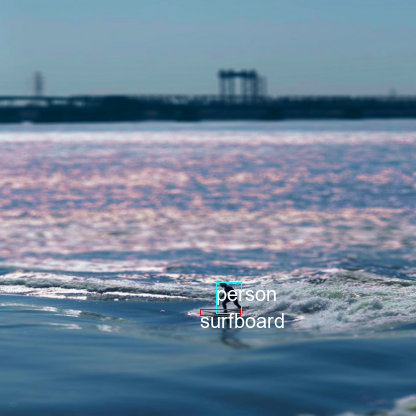

In [141]:
draw_bbox_class(trans.ToPILImage()(de_preprocess(imgs[i].cpu(),conf.mean,conf.std)),labels_group[i],bboxes_group[i],correct_id_2_class)

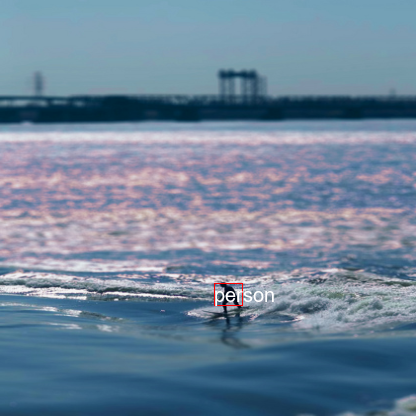

In [142]:
trans.ToPILImage()(yolo.predict(imgs[i],conf,0.5,return_img=True))

In [127]:
yolo.predict(imgs[i],conf,0.5,return_img=False)

(tensor([[ 207.6052,  175.9515,  287.2327,  472.8893]], device='cuda:0'),
 tensor([ 0], device='cuda:0'),
 tensor([ 0.9971], device='cuda:0'))

In [94]:
labels_group[i]

tensor([  0,  36,  24,   0])

In [95]:
bboxes_group[i]

tensor([[ 329.2543,  260.3223,  151.1835,  216.5349],
        [  18.1740,  227.0715,   36.3220,   25.2139],
        [ 322.9102,  334.1037,   46.6115,   53.4453],
        [  23.3610,  115.6695,   46.4880,  218.3902]])

In [78]:
correct_id_2_class[30]

'skis'

In [70]:
conf.coco_anchors[6:]

[[116, 90], [156, 198], [373, 326]]

In [69]:
yolo.yolo_loss_large.anchors * 32

tensor([[ 116.,   90.],
        [ 156.,  198.],
        [ 373.,  326.]], device='cuda:0')

In [56]:
380/25

15.2

In [57]:
1444/76

19.0

In [10]:
yolo.save_state(conf,341.3,'ft_6_epoch')

In [ ]:
log_lrs, losses = yolo.find_lr(conf)

plt.plot(log_lrs[10:],losses[10:])

In [ ]:
yolo.model.load_state_dict(torch.load(conf.model_path/'2018-06-13-18-03_f1:0.00189505697472956_cls_acc:0.000657030223390276_model_seen:58628_ft.pth'))
yolo.optimizer.load_state_dict(torch.load(conf.model_path/'2018-06-13-18-03_f1:0.00189505697472956_cls_acc:0.000657030223390276_optimizer_seen:58628_ft.pth'))

In [ ]:
yolo.optimizer.param_groups[0]['lr'] = 1e-2

In [ ]:
log_lrs, losses = yolo.find_lr(conf)

plt.plot(log_lrs[10:],losses[10:])